# Reducing NBA Injuries

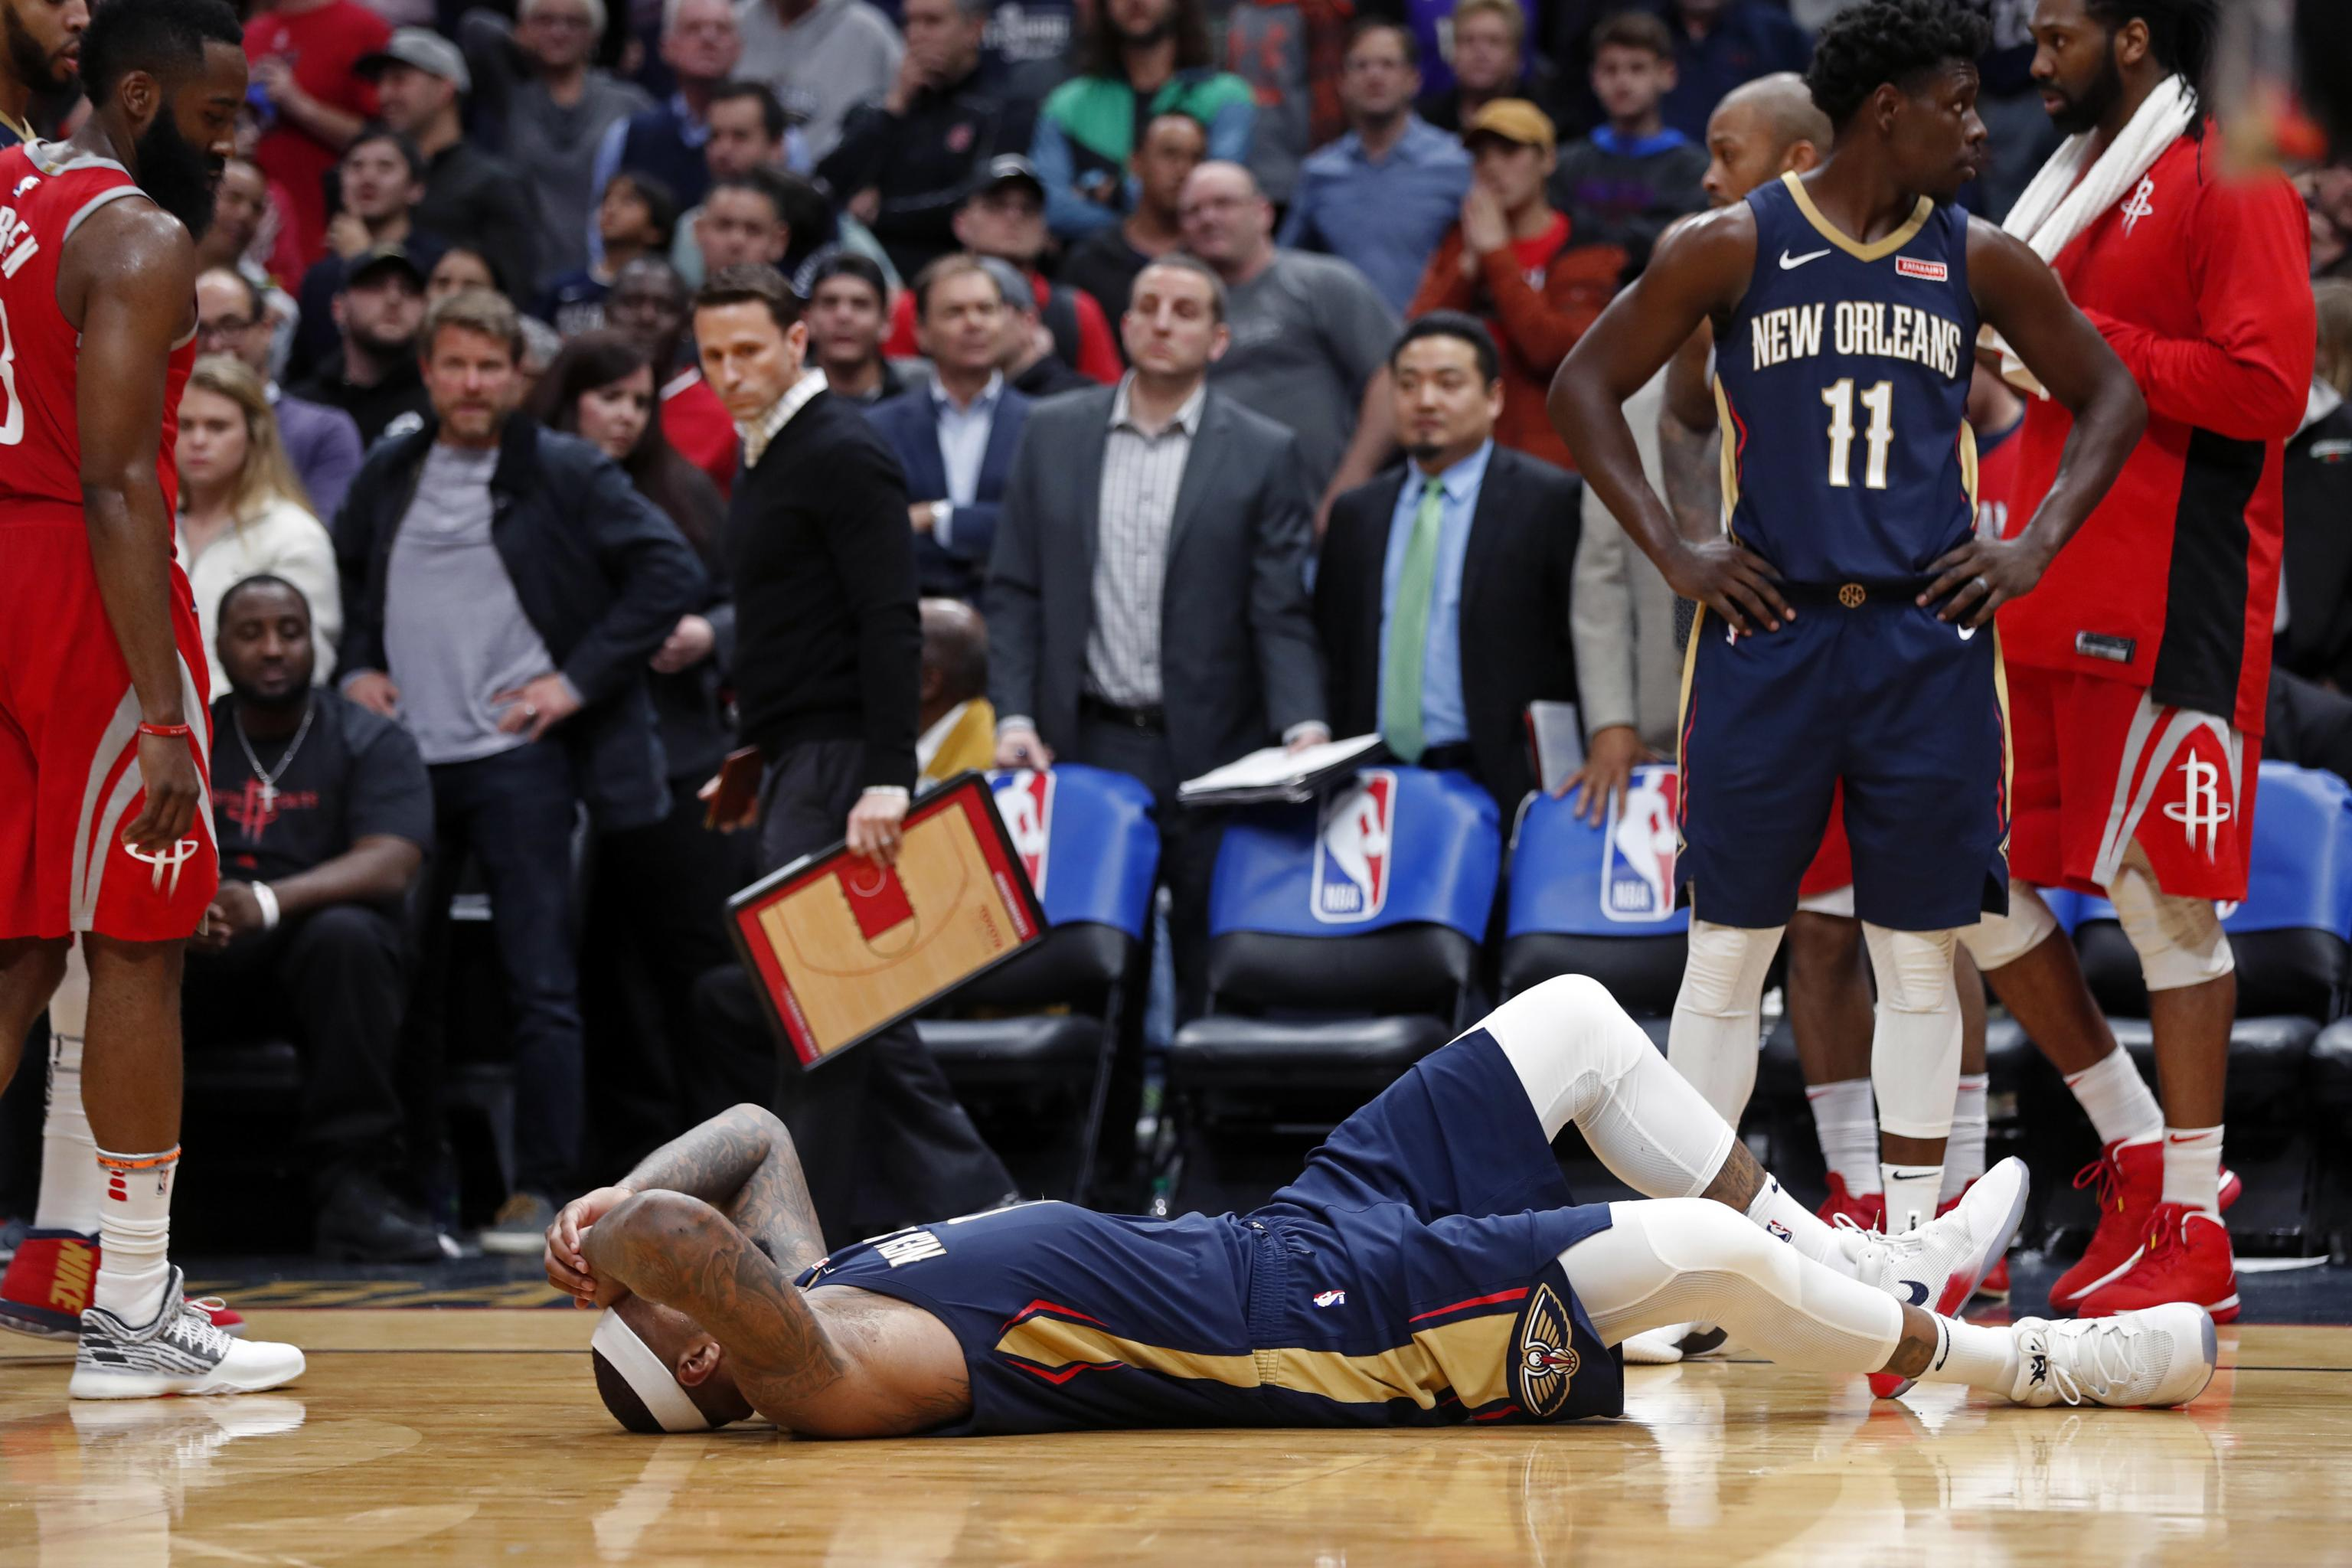

## Background

Season ending injuries are some of the most devastating for NBA players. Not even a decade ago most of these injuries, including ACL and Achilles tendon ruptures, were nearly always career-ending. While medical technology has advanced since then, season-ending injuries are still extremely distressing for players, front office staff, and fans. Given the physical, emotional, and financial toll of these injuries, I sought to quantify risk factors and develop a model to identify NBA players at high risk for season-ending injuries.

## Data Understanding

Using a NBA injury dataset from Kaggle with more than 17,000 entries over 9 seasons and NBA player stats, I created a combined dataset which links prior season stats with current season injury profile to assess risk of season-ending injury. The hope is that such a model may be used to identify at-risk players and modify their activity to reduce risk of injury. This would benefit both NBA players and other stakeholders.

## EDA

In [52]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
import gzip as gz
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=(RuntimeWarning))
import itertools 
import pickle
from zipfile import ZipFile
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from statsmodels.api import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [53]:
# Load and explore dataset
# nba = 'Data/NBAInjuries.zip'
# with ZipFile(nba, 'r') as zip:
#     zip.extractall('Data/nba_unzipped')
    
df = pd.read_csv('Data/nba_unzipped/injuries_2010-2020.csv')
df

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)
...,...,...,...,...,...
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left foot
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL


In [54]:
# Drop Acquired column, null values, and rename Relinquished to Name
df.drop(['Acquired'], axis=1, inplace=True)
df.dropna(inplace=True)
df.rename(columns={'Relinquished':'Name'}, inplace=True)
df.head()

,Date,Team,Name,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out indefinitely)
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out indefinitely)
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [55]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17558 non-null  object
 1   Team    17558 non-null  object
 2   Name    17558 non-null  object
 3   Notes   17558 non-null  object
dtypes: object(4)
memory usage: 685.9+ KB


In [56]:
# Create series of Notes column
s1 = df.Notes

In [57]:
# Quantify season ending injuries 
out_for_season = s1.str.contains('out for season', case=False)
out_for_season.value_counts()

False    16433
True      1125
Name: Notes, dtype: int64

In [58]:
# Binary label out_of_season as target
df = df.assign(out_for_season=pd.Series(out_for_season).values)
df = df*1

# Dataset of injuries that resulted in player being out_of_season
ofs = df[(df['Notes'].str.contains('out for season', case=False))]
ofs.head()

,Date,Team,Name,Notes,out_for_season
8,2010-10-12,Bucks,Darington Hobson,surgery on left hip (out for season),1
17,2010-10-26,Blazers,Greg Oden,placed on IL with left knee injury (out for season),1
75,2010-10-27,Pistons,Jonas Jerebko,placed on IL recovering from surgery to repair torn right Achilles tendon (out for season),1
76,2010-10-27,Pistons,Terrico White,placed on IL recovering from surgery on right foot to repair broken fifth metatarsal (out for season),1
175,2010-11-04,Blazers,Elliot Williams,"dislocated patella in right knee (surgery, out for season)",1


In [59]:
# Split injury data by season
ofs_10 = ofs[(ofs['Date'] < '2011-07-01')]
ofs_11 = ofs[(ofs['Date'].between('2011-07-01','2012-07-01'))]
ofs_12 = ofs[(ofs['Date'].between('2012-07-01','2013-07-01'))]
ofs_13 = ofs[(ofs['Date'].between('2013-07-01','2014-07-01'))]
ofs_14 = ofs[(ofs['Date'].between('2014-07-01','2015-07-01'))]
ofs_15 = ofs[(ofs['Date'].between('2015-07-01','2016-07-01'))]
ofs_16 = ofs[(ofs['Date'].between('2016-07-01','2017-07-01'))]
ofs_17 = ofs[(ofs['Date'].between('2017-07-01','2018-07-01'))]
ofs_18 = ofs[(ofs['Date'].between('2018-07-01','2019-07-01'))]

Multiple entries for same player and injury are noted. Let us remove the duplicates.

In [60]:
# Function to drop duplicates
def DropDuplicates(dataset):
    dataset = dataset.drop_duplicates(subset=['Name'])
    return dataset

# Make list of season datasets
list_ofs = [ofs_10, ofs_11, ofs_12, ofs_13, ofs_14, ofs_15,
            ofs_16, ofs_17, ofs_18]

# Apply function
nodups = [DropDuplicates(season) for season in list_ofs]

Import NBA player stats

In [61]:
# Import player stats
p09 = pd.read_excel('Data/player_stats/2009-2010.xlsx')
p10 = pd.read_excel('Data/player_stats/2010-2011.xlsx')
p11 = pd.read_excel('Data/player_stats/2011-2012.xlsx')
p12 = pd.read_excel('Data/player_stats/2012-2013.xlsx')
p13 = pd.read_excel('Data/player_stats/2013-2014.xlsx')
p14 = pd.read_excel('Data/player_stats/2014-2015.xlsx')
p15 = pd.read_excel('Data/player_stats/2015-2016.xlsx')
p16 = pd.read_excel('Data/player_stats/2016-2017.xlsx')
p17 = pd.read_excel('Data/player_stats/2017-2018.xlsx')

# Read 2018 data for chart creation
p18 = pd.read_excel('Data/player_stats/2018-2019.xlsx')

# Make list of season datasets
list_p = [p10, p11, p12, p13, p14,
            p15, p16, p17, p18]

In [62]:
# Merge stats dataset with injury dataset
s09 = pd.merge(p09,nodups[0], how='left', on='Name')
s10 = pd.merge(p10,nodups[1], how='left', on='Name')
s11 = pd.merge(p11,nodups[2], how='left', on='Name')
s12 = pd.merge(p12,nodups[3], how='left', on='Name')
s13 = pd.merge(p13,nodups[4], how='left', on='Name')
s14 = pd.merge(p14,nodups[5], how='left', on='Name')
s15 = pd.merge(p15,nodups[6], how='left', on='Name')
s16 = pd.merge(p16,nodups[7], how='left', on='Name')
s17 = pd.merge(p17,nodups[8], how='left', on='Name')

Now let us build a chart to visualize the incidence of season ending injury in the NBA by season.

In [63]:
# For loop calculating injury incidence
inj_incidence=[]
for inj,p in itertools.zip_longest(nodups,list_p):
    inj_incidence.append(len(inj.index)/len(p.index))

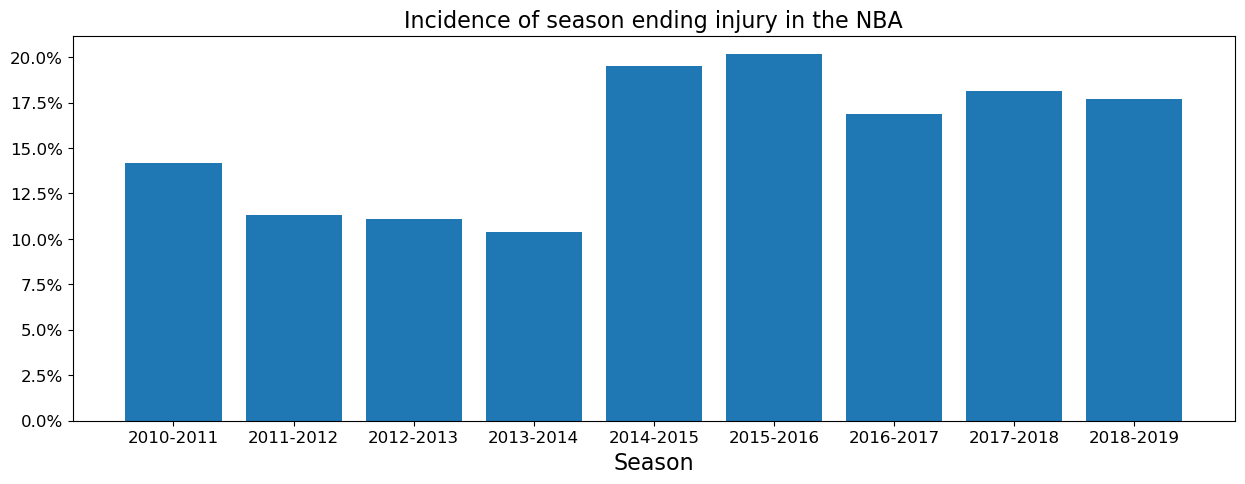

In [64]:
# Build chart
x=['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019']
y=inj_incidence
fig, ax = plt.subplots(figsize=(15,5))
bars = ax.bar(x,y)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlabel('Season', size=16)
ax.set_title('Incidence of season ending injury in the NBA', size=16);

In [65]:
#Dataframe of injury incidence
pd.DataFrame(y,x)

,0
2010-2011,0.141593
2011-2012,0.112971
2012-2013,0.110874
2013-2014,0.103734
2014-2015,0.195122
2015-2016,0.201681
2016-2017,0.168724
2017-2018,0.181481
2018-2019,0.177024


In [66]:
# Concatenate season datasets into main dataset
df_con = pd.concat([s09,s10,s11,s12,s13,s14,s15,s16,s17], axis=0)
df_con.head()

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,6-1,161,Oregon,USA,2007,1,26,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,NaN
1,Aaron Gray,NOH,25,7-1,270,Pittsburgh,USA,2007,2,49,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,NaN
2,Acie Law,CHI,25,6-3,202,Texas A&M,USA,2007,1,11,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1.0
3,Adam Morrison,LAL,25,6-8,205,Gonzaga,USA,2006,1,3,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,NaN
4,AJ Price,IND,23,6-2,181,Connecticut,USA,2009,2,52,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,NaN


## Data Cleaning and Feature Engineering

Let the data cleaning begin: Converting height into inches, binary binning country and college columns, converting objects to numeric datatypes.

In [67]:
# Function to convert ft-in height into inches
def parse_ht(height):
    ht_ = height.split("-")
    ft_ = int(ht_[0])
    in_ = int(ht_[1])
    return (12*ft_) + in_
df_con["HEIGHT"] = df_con["HEIGHT"].apply(lambda x:parse_ht(x))

In [68]:
# Binary bin Country['USA'] = 1, other = 0
df_con.COUNTRY.replace(to_replace='USA', value=1, inplace=True) 
df_con.loc[df_con['COUNTRY'] != 1, 'COUNTRY'] = 0
df_con['COUNTRY'] = df_con['COUNTRY'].astype(int)
df_con.COUNTRY.value_counts()

1    3456
0     861
Name: COUNTRY, dtype: int64

In [69]:
# Binary bin College = 1 , no College = 0
df_con.COLLEGE.replace(to_replace='None', value=0, inplace=True)
df_con.loc[df_con['COLLEGE'] != 0, 'COLLEGE'] = 1
df_con['COLLEGE'] = df_con['COLLEGE'].astype(int)
df_con.COLLEGE.value_counts()

1    3572
0     745
Name: COLLEGE, dtype: int64

In [70]:
# Replace Undrafted and Nan with 0
df_con.replace(to_replace='Undrafted', value=0, inplace=True)
df_con['out_for_season'].fillna(0, inplace=True)

In [71]:
# DRAFT YEAR, DRAFT ROUND, and DRAFT NUMBER dropped because undrafted player data was not recorded
df_con.drop(['DRAFT YEAR', 'DRAFT ROUND', 'DRAFT NUMBER'], axis=1, inplace=True)

In [72]:
# Function to convert strings to numeric
def MakeNumeric(Column):
    df_con[Column] = df_con[Column].astype(int)
    return df_con

# Make list of columns to be converted to numeric values
make_columns_numeric = ['COUNTRY', 'COLLEGE', 'out_for_season']

# Apply function
make_columns_numeric = [MakeNumeric(column) for column in make_columns_numeric]

In [73]:
# Updating team names
df_con.TEAM = df_con.TEAM.replace({'NOH':'NOP','NJN':'BKN'}) 
df_con

,Name,TEAM,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season
0,Aaron Brooks,HOU,25,73,161,1,1,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0
1,Aaron Gray,NOP,25,85,270,1,1,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0
2,Acie Law,CHI,25,75,202,1,1,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1
3,Adam Morrison,LAL,25,80,205,1,1,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0
4,AJ Price,IND,23,74,181,1,1,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,POR,20,85,230,1,1,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0
536,Zach LaVine,CHI,23,77,185,1,1,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,2019-03-20,Bulls,bruised right thigh (out for season),1
537,Zach Randolph,SAC,36,81,250,1,1,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0
538,Zaza Pachulia,GSW,34,83,270,0,0,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,NaN,NaN,NaN,0


In [74]:
# Dummify Teams
df_con = pd.get_dummies(df_con, columns=['TEAM'])
df_con

,Name,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,Date,Team,Notes,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,Aaron Brooks,25,73,161,1,1,82,0.2,0.549,42,40,35.6,19.6,7.0,16.2,43.2,2.5,6.4,39.8,3.0,3.6,82.2,0.7,2.0,2.6,5.3,2.8,0.8,0.2,2.4,30.9,6,0,-0.3,2919,25.4,25.1,26.2,41.5,37.8,22.5,21.1,8.1,8.8,8.6,32.7,27.0,16.2,6.2,21.3,16.3,19.7,26.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Gray,25,85,270,1,1,32,-3.1,0.551,11,21,9.7,3.3,1.3,2.6,51.2,0.0,0.0,0.0,0.6,0.9,71.4,1.4,1.9,3.3,0.7,0.6,0.3,0.3,1.7,9.6,0,0,-0.4,311,16.0,17.2,15.4,0.0,0.0,21.5,23.1,52.3,30.8,37.3,16.5,18.0,18.0,35.5,25.0,37.5,18.5,16.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Acie Law,25,75,202,1,1,26,5.3,0.585,11,15,9.0,4.3,1.3,2.9,46.7,0.2,0.6,31.3,1.5,1.9,77.6,0.1,0.5,0.7,1.0,0.7,0.4,0.0,0.6,7.4,0,0,0.8,234,21.4,18.6,19.4,14.7,18.4,29.9,30.4,6.1,10.3,9.2,26.0,29.8,24.4,4.2,39.4,14.0,27.8,21.0,2011-03-29,Warriors,placed on IL with right wrist injury (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adam Morrison,25,80,205,1,1,31,-8.3,0.418,23,8,7.8,2.4,1.0,2.7,37.6,0.2,0.7,23.8,0.2,0.3,62.5,0.3,0.7,1.0,0.6,0.3,0.1,0.1,0.5,4.7,0,0,-1.2,241,17.8,17.7,20.1,13.9,21.2,6.8,7.7,16.4,13.6,14.3,16.8,13.9,10.0,8.0,30.0,20.2,5.8,15.7,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AJ Price,23,74,181,1,1,56,3.9,0.530,23,33,15.5,7.3,2.6,6.3,41.0,1.1,3.1,34.5,1.1,1.3,80.0,0.2,1.4,1.6,1.9,1.1,0.6,0.1,0.9,13.0,0,0,0.9,865,21.9,21.3,23.2,32.4,34.3,19.2,18.0,7.4,13.4,12.1,27.4,21.5,25.5,3.2,23.8,13.6,20.2,22.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Zach Collins,20,85,230,1,1,66,1.3,0.475,41,25,15.8,4.4,1.7,4.4,39.8,0.5,1.7,31.0,0.4,0.6,64.3,0.7,2.7,3.3,0.8,0.9,0.3,0.5,2.0,10.9,0,0,0.2,1045,15.3,13.5,15.7,14.6,18.4,8.8,10.6,20.8,22.8,22.4,12.7,19.3,14.7,34.8,16.2,28.2,12.6,12.9,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
536,Zach LaVine,23,77,185,1,1,24,-12.1,0.499,9,15,27.3,16.7,5.7,14.8,38.3,1.8,5.1,34.1,3.6,4.5,81.3,0.4,3.5,3.9,3.0,1.8,1.0,0.2,2.3,27.6,0,0,-7.2,656,29.0,26.1,29.5,30.4,30.5,39.2,37.5,7.5,18.4,16.2,24.7,25.1,23.3,8.9,43.5,20.2,28.8,28.6,2019-03-20,Bulls,bruised right thigh (out for season),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537,Zach Randolph,36,81,250,1,1,59,-12.2,0.529,18,41,25.6,14.5,6.1,12.9,47.3,0.9,2.5,34.7,1.4,1.8,78.5,1.6,5.1,6.7,2.2,2.0,0.7,0.2,2.0,26.5,8,0,-6.0,1508,27.0,29.3,28.2,18.5,20.3,23.2,21.4,32.6,30.4,30.9,19.1,26.0,18.1,9.5,26.7,19.6,26.1,27.6,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
538,Zaza Pachulia,34,83,270,0,0,69,9.4,0.612,47,22,14.1,5.4,2.2,3.8,56.4,0.0,0.0,0.0,1.1,1.3,80.6,1.3,3.4,4.7,1.6,1.0,0.6,0.2,1.8,14.7,2,0,2.8,972,16.5,16.1,14.8,0.0,0.2,26.8,28.0,48.4,32.4,35.6,16.3,22.6,24.4,15.0,39.8,36.6,27.5,15.5,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
df_con.describe()

,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,GP,NETRTG,TS%,W,L,MPG,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,MIN,USG%,%FGM,%FGA,%3PM,%3PA,%FTM,%FTA,%OREB,%DREB,%REB,%AST,%TOV,%STL,%BLK,%BLKA,%PF,%PFD,%PTS,out_for_season,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,TEAM_DEN,TEAM_DET,TEAM_GSW,TEAM_HOU,TEAM_IND,TEAM_LAC,TEAM_LAL,TEAM_MEM,TEAM_MIA,TEAM_MIL,TEAM_MIN,TEAM_NOP,TEAM_NYK,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.00000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000
mean,26.962474,79.158907,221.557331,0.827426,0.800556,52.444753,-2.139958,0.515802,26.248552,26.196201,20.206185,8.198193,3.071253,6.844174,43.816817,0.641209,1.832708,25.254969,1.418346,1.885685,70.110100,0.901158,2.645217,3.544035,1.800556,1.150961,0.635441,0.405513,1.746583,17.117443,4.237433,0.118601,-0.345587,1213.017836,18.136808,18.260459,18.699884,17.300695,18.111026,17.341788,17.885013,20.508548,19.694811,19.985268,18.098494,18.254413,19.262868,19.996965,19.168334,22.005606,18.362613,18.105791,0.121149,0.032893,0.036368,0.033356,0.033588,0.031735,0.034978,0.034746,0.032198,0.031040,0.032198,0.033125,0.03243,0.033356,0.033820,0.036368,0.033125,0.034283,0.032662,0.036136,0.033820,0.033356,0.031040,0.034051,0.032198,0.031503,0.032198,0.033588,0.033125,0.032662,0.034051
std,4.262036,3.553347,26.616005,0.377922,0.399629,24.696246,11.887091,0.097981,15.968330,14.620618,9.457667,5.742736,2.096509,4.436207,9.832629,0.695200,1.816217,16.981427,1.338567,1.664693,19.822599,0.809434,1.769777,2.446181,1.778900,0.778435,0.428340,0.438700,0.751397,10.486305,9.174975,1.071935,2.927873,857.427097,5.197265,6.358304,5.841734,15.369848,14.433505,10.430400,10.074568,15.437418,8.832157,9.685951,12.663147,8.054364,9.776307,17.953947,11.251355,8.907587,8.941240,6.191234,0.326338,0.178378,0.187225,0.179587,0.180187,0.175314,0.183745,0.183158,0.176547,0.173446,0.176547,0.178983,0.17716,0.179587,0.180786,0.187225,0.178983,0.181976,0.177770,0.186651,0.180786,0.179587,0.173446,0.181382,0.176547,0.174694,0.176547,0.180187,0.178983,0.177770,0.181382
min,19.000000,65.000000,133.000000,0.000000,0.000000,1.000000,-150.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.000000,200.000000,1.000000,1.000000,33.000000,-6.200000,0.488000,13.000000,15.000000,12.600000,3.800000,1.400000,3.400000,40.000000,0.000000,0

In [76]:
# Engineering features
df_con['BMI'] = (df_con['WEIGHT'] / df_con['HEIGHT']**2) * 703
df_con['Loss%'] = df_con['L'] / df_con['GP']

In [77]:
# Domain knowledge features
good_features = ['AGE', 'BMI', 'Loss%', 'COLLEGE', 'COUNTRY', 'GP', 'NETRTG', 'MPG', 'PTS',
                'FGA', '3PA', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'PF',
                'DD2', 'TD3', '+/-', 'MIN', 'USG%', '%FGA', 
                '%3PA',  '%FTA', '%OREB', '%DREB', '%AST', '%TOV',
                '%STL', '%BLK', '%BLKA', '%PF', '%PFD', '%PTS']

# Teams
teams = ['TEAM_ATL', 'TEAM_BKN', 'TEAM_BOS', 'TEAM_CHA',
       'TEAM_CHI', 'TEAM_CLE', 'TEAM_DAL', 'TEAM_DEN', 'TEAM_DET', 'TEAM_GSW',
       'TEAM_HOU', 'TEAM_IND', 'TEAM_LAC', 'TEAM_LAL', 'TEAM_MEM', 'TEAM_MIA',
       'TEAM_MIL', 'TEAM_MIN', 'TEAM_NOP', 'TEAM_NYK',
       'TEAM_OKC', 'TEAM_ORL', 'TEAM_PHI', 'TEAM_PHX', 'TEAM_POR', 'TEAM_SAC',
       'TEAM_SAS', 'TEAM_TOR', 'TEAM_UTA', 'TEAM_WAS']

best_features = good_features + teams

Assign X and y values, train_test_split, scale data.

In [78]:
# Assign X and y. 
y = df_con.out_for_season
X = df_con[best_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.10, random_state=22) 

Assess for high multicollinearity via Variance Inflation Factor (VIF).

In [79]:
# Calculate feature VIF
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif["features"] = X_train.columns
vif.sort_values(by="VIF",ascending=False, inplace=True)
vif.head(25)

,VIF,features
8,104.870863,PTS
9,79.663815,FGA
23,56.070756,USG%
7,29.735541,MPG
24,25.935819,%FGA
51,15.620917,TEAM_MEM
38,15.598296,TEAM_BKN
42,14.821872,TEAM_CLE
59,14.794246,TEAM_PHI
50,14.725975,TEAM_LAL


There seems to be quite a lot of highly multicollinear features. Let us isolate wanted features using a VIF of 10 as a cutoff per convention.

In [80]:
# Create dataframe of features with VIF < 10
vif = vif[(vif['VIF'] < 10)]
vif

,VIF,features
22,8.182526,MIN
12,8.177494,OREB
26,6.899074,%FTA
36,6.694178,%PTS
10,6.222191,3PA
30,5.638049,%TOV
18,5.407334,PF
27,5.082329,%OREB
16,5.081052,STL
19,4.753304,DD2


In [81]:
# Assign features with VIF < 10 to list vif_features
vif_features = vif.features.to_list()
vif_features

['MIN',
 'OREB',
 '%FTA',
 '%PTS',
 '3PA',
 '%TOV',
 'PF',
 '%OREB',
 'STL',
 'DD2',
 '%PFD',
 '%3PA',
 'BLK',
 '%AST',
 'GP',
 '+/-',
 '%BLK',
 '%DREB',
 '%PF',
 'NETRTG',
 'Loss%',
 '%STL',
 'COUNTRY',
 'COLLEGE',
 '%BLKA',
 'TD3',
 'BMI',
 'AGE']

In [82]:
# Apply vif_features to X_train and X_test
X_train = X_train[vif_features]
X_test = X_test[vif_features]

In [83]:
# Assess target variable balance
y.value_counts(), y.value_counts(normalize = True)

(0    3794
 1     523
 Name: out_for_season, dtype: int64,
 0    0.878851
 1    0.121149
 Name: out_for_season, dtype: float64)

Given the target variable imbalance will elect to SMOTE the training set.

### SMOTE

In [84]:
# SMOTE to oversample minority class
sm = SMOTE(random_state=22)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
smote_counter = Counter(y_smote)
print(counter)
print(smote_counter)

Counter({0: 3414, 1: 471})
Counter({0: 3414, 1: 3414})


We now have evenly matched target variables. Let's reassign the smote training set to X_train and y_train and re-scale for later use.

In [85]:
# Reassign X_smote and y_smote to y_train
X_train = X_smote.copy()
y_train = y_smote.copy()

# Re-scale data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# Pickle scaler for later use on new data
pickle.dump(scale, open('scale.sav', 'wb'))

## Modeling

This is a binary classification study with out_for_season as the target variable. Independent variables with VIF > 10 were excluded from analysis as they demonstrated high multicollinearity. A Pipeline will be used to expedite the modeling process. A DummyClassifier will be used to generate a baseline model. Four classification models will then be used to analyze the data: Logistic Regression, Random Forest, XGBoost, and an ensemble model comprised of the previous three models. Additionally, odds ratios for the most impactful risk factors for season-ending injury will be calculated following the Logistic Regression analysis. Though false negatives are more detrimental than false positives in the current context, accuracy was chosen to be the primary metric of model evaluation given its common usage. f1_score and ROC AUC will be used as secondary metrics.

### Pipeline Construction

In [36]:
# Function with classifier input and pipeline output
def pipe_maker(classifier):
    pipe = Pipeline([('scl', StandardScaler()), 
                     ('clf', classifier(random_state=22))])
    return pipe

In [37]:
# Function with Pipeline & Parameters input and gridsearch with optimum parameters output. Optimize for f1_score to mitigate class bias.
def gridsearch_maker(pipeline, params):
    return GridSearchCV(estimator=pipeline,
                        param_grid=params,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)

In [38]:
# Function with pipline/gridsearch input and optimized hyperparameters output
def best_acc(gridsearch):

    # Fit gridsearch to regularized data set
    gridsearch.fit(X_train, y_train)
    
    # Print best parameters
    print('Best paramaters are: %s' % gridsearch.best_params_)
    
    # Print best train accuracy_score
    print('Best training accuracy_score: %.3f' % gridsearch.best_score_)
    
    # Prediction on scaled test data
    y_hat_test = gridsearch.predict(X_test)
    
    # Print test data accuracy_score with best params
    print('Test accuracy_score with best parameters: %.3f ' % accuracy_score(y_test, y_hat_test))
    
    # Print confusion matrix and classification report
    print('Test: ', classification_report(y_test, y_hat_test, zero_division=0))
    
    # Plot confusion matrix and ROC_AUC
    ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test,cmap="plasma")
    RocCurveDisplay.from_estimator(gridsearch, X_test, y_test);

Model away...

### Model 0: DummyClassifier Baseline Model

We will start with a DummyClassifer Model to form a baseline model whose prediction is no better than chance.

Best paramaters are: {'clf__strategy': 'most_frequent'}
Best training accuracy_score: 0.499
Test accuracy_score with best parameters: 0.880 
Test:                precision    recall  f1-score   support

           0       0.88      1.00      0.94       380
           1       0.00      0.00      0.00        52

    accuracy                           0.88       432
   macro avg       0.44      0.50      0.47       432
weighted avg       0.77      0.88      0.82       432



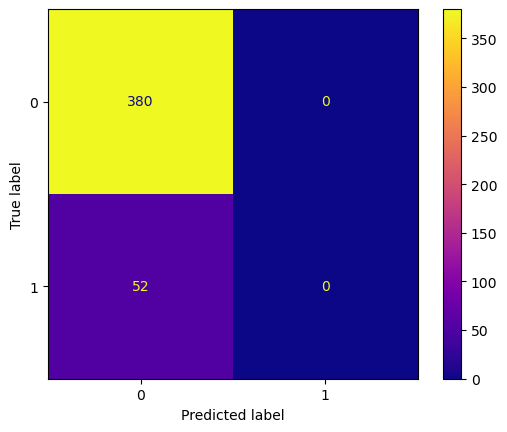

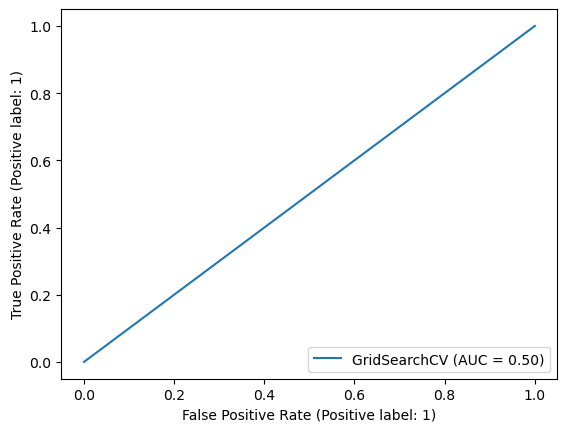

In [39]:
# Dummy Classifier Model
pipe_dc = pipe_maker(DummyClassifier)
grid_params_dc = [{'clf__strategy': ["most_frequent","prior"]}]
gs_dc = gridsearch_maker(pipe_dc, grid_params_dc)
best_acc(gs_dc)

DummyClassification model produces an accuracy of 88%, an f1-score of 0%, and a ROC AUC of 50% as expected.

### Model 1: Logistic Regression Model

/Users/richardhinds/opt/anaconda3/envs/streamlit/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.63605793 0.63620456 0.6357651  0.6357651         nan        nan
 0.63605793 0.63620456 0.6357651  0.6357651         nan        nan
 0.63605793 0.63620456 0.6357651  0.6357651         nan        nan
 0.59446379 0.59431738 0.59431716 0.59417075        nan        nan
 0.59446379 0.59431738 0.59431716 0.59417075        nan        nan
 0.59446379 0.59431738 0.59431716 0.59417075        nan        nan
 0.63620434 0.63605793 0.63561869 0.63561869        nan        nan
 0.63620434 0.63605793 0.63561869 0.63561869        nan        nan
 0.63620434 0.63605793 0.63561869 0.63561869        nan        nan
 0.59431738 0.59431738 0.59417075 0.59417075        nan        nan
 0.59431738 0.59431738 0.59417075 0.59417075        nan        nan
 0.59431738 0.59431738 0.59417075 0.59417075        nan        nan
 0.63576532 0.63561

Best paramaters are: {'clf__C': 1, 'clf__class_weight': {0: 1, 1: 1.75}, 'clf__max_iter': 100, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best training accuracy_score: 0.636
Test accuracy_score with best parameters: 0.468 
Test:                precision    recall  f1-score   support

           0       0.97      0.41      0.57       380
           1       0.17      0.90      0.29        52

    accuracy                           0.47       432
   macro avg       0.57      0.66      0.43       432
weighted avg       0.87      0.47      0.54       432



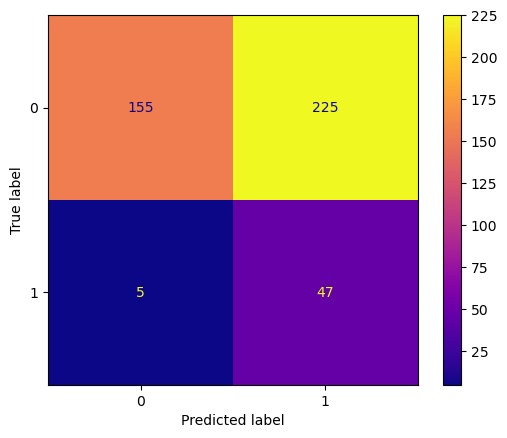

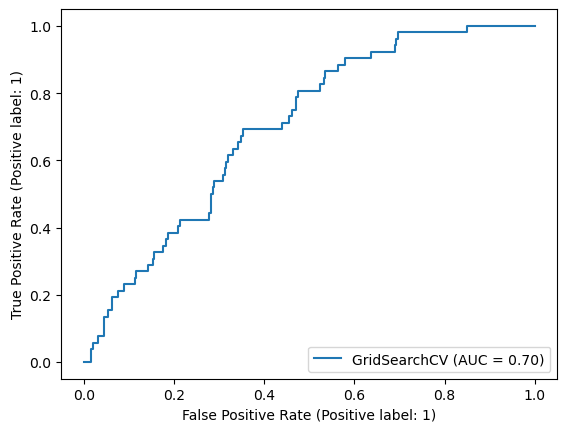

In [40]:
# Logistic Regression Model
pipe_lr = pipe_maker(LogisticRegression)
grid_params_lr = [{'clf__penalty': ['l1', 'l2', 'elasticnet'],
                  'clf__solver': ['liblinear', 'saga'],
                  'clf__C': [1,2,3],
                  'clf__class_weight':[{0:1,1:1.75},{0:1,1:2.5}],
                  'clf__max_iter': [100,1000,10000]}]
gs_lr = gridsearch_maker(pipe_lr, grid_params_lr)
best_acc(gs_lr)

LogisticRegression with GridSearchCV hyperparameter optimization resulted in an accuracy of 47%, f1-score of 29%, and ROC AUC was 70%. Now we will quantify the risk factors by calculating the coefficients on the optimized parameter model.

In [41]:
# Instantiate, fit, and run model with best parameters
lr = LogisticRegression(max_iter=100, C = 1, class_weight= {0:1,1:1.75}, penalty='l1', solver='saga')
lr.fit(X_train_scaled, y_train)
print(np.exp(lr.coef_))
COEF = np.exp(lr.coef_[0])
odds = pd.DataFrame(COEF, X_train.columns, 
        columns=['odds']).sort_values(by='odds', ascending=False)

# View odds ratios and identify top 5 risk factors
odds.head()

[[1.37632968 1.19075406 1.05387538 0.98872375 1.3415351  0.89250138
  1.32340094 0.95021163 1.04634779 0.87182182 1.         0.86986777
  1.08239718 1.07388725 0.80814527 0.86595943 0.89101069 1.07189808
  0.88474141 1.0949325  0.83586755 1.02588106 0.79626893 0.69425025
  0.95351736 0.94183842 0.95851351 0.81449015]]


,odds
MIN,1.376330
3PA,1.341535
PF,1.323401
OREB,1.190754
NETRTG,1.094933


Here we see the 5 most impactful prior season risk factors for sustaining season-ending injuries are:
1. Cumulative Minutes per Season 
2. 3-Pointers Attempted per Game
3. Player Fouls per Game
4. Offensive Rebounds per Game
5. Net Rating

Now let us compare the top 3 risk factors between those who sustained season ending injuries and those who did not

In [42]:
# Separate data into injured and noninjured cohorts
injured = df_con[(df_con['out_for_season']) == 1]
uninjured = df_con[(df_con['out_for_season']) == 0]

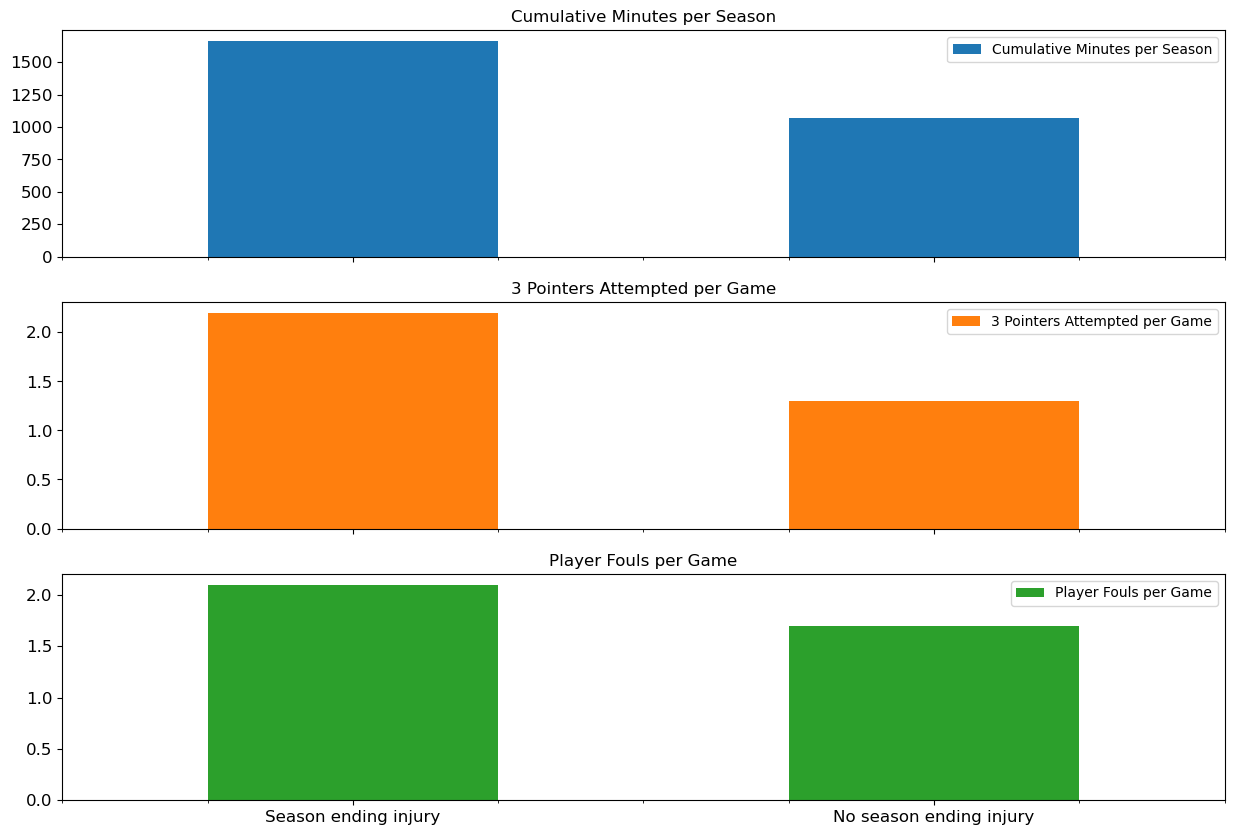

In [43]:
# Build chart comparing PF, weight, and 3P% between injury and non-injury cohorts
x=['Season ending injury','No season ending injury']
mins=[injured.MIN.median(),uninjured.MIN.median()]
thrs=[injured['3PA'].median(),uninjured['3PA'].median()]
pfs=[injured.PF.median(),uninjured.PF.median()]
r3 = pd.DataFrame({"Cumulative Minutes per Season":mins,'3 Pointers Attempted per Game':thrs,'Player Fouls per Game':pfs}, index=x)
axes = r3.plot.bar(rot=0, subplots=True, figsize=(15,10),fontsize=12)
axes[1].legend(loc=1);

In [44]:
# View the values
(mins, thrs, pfs)

([1663.0, 1073.0], [2.2, 1.3], [2.1, 1.7])

Here we can visualize the differences between the season ending injury cohort and the cohort that did not sustain season ending injuries.

Let us move on to more advance models.

### Model 2: Random Forest Model

Best paramaters are: {'clf__class_weight': {0: 1, 1: 5}, 'clf__criterion': 'entropy', 'clf__max_depth': 50}
Best training accuracy_score: 0.919
Test accuracy_score with best parameters: 0.854 
Test:                precision    recall  f1-score   support

           0       0.90      0.94      0.92       380
           1       0.32      0.19      0.24        52

    accuracy                           0.85       432
   macro avg       0.61      0.57      0.58       432
weighted avg       0.83      0.85      0.84       432



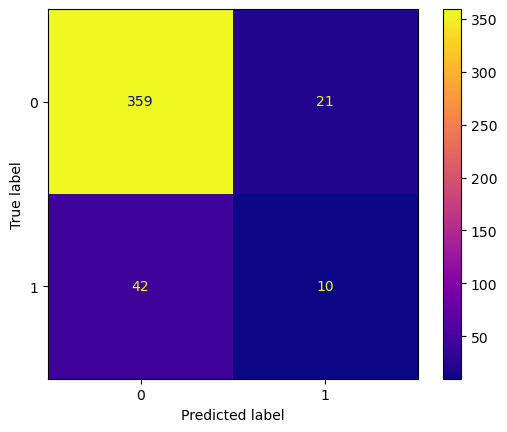

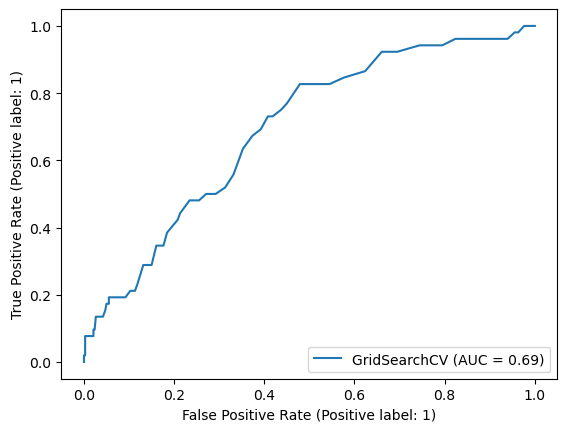

In [45]:
# Random Forest Model
pipe_rfc = pipe_maker(RandomForestClassifier)
grid_params_rfc = [{'clf__criterion': ['gini', 'entropy'],
                  'clf__max_depth': [25,50,100],
                  'clf__class_weight': [{0:1,1:5},{0:1,1:10}]}]
gs_rfc = gridsearch_maker(pipe_rfc, grid_params_rfc)
best_acc(gs_rfc)

RandomForestClassifier with  GridSearchCV hyperparameter optimization performed better than LogisticRegression achieving 85% accuracy,  24% f1-score, and 69% ROC AUC. Let us see how XGBoost will perform.

### Model 3: XGBoost Model

/Users/richardhinds/opt/anaconda3/envs/streamlit/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.79467117 0.77064873 0.84739741 0.82850479 0.85809135 0.84315101
 0.5        0.5        0.5        0.5        0.5        0.5
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


Best paramaters are: {'clf__booster': 'gbtree', 'clf__eta': 0.75, 'clf__scale_pos_weight': 1000}
Best training accuracy_score: 0.858
Test accuracy_score with best parameters: 0.718 
Test:                precision    recall  f1-score   support

           0       0.90      0.77      0.83       380
           1       0.18      0.37      0.24        52

    accuracy                           0.72       432
   macro avg       0.54      0.57      0.53       432
weighted avg       0.81      0.72      0.76       432



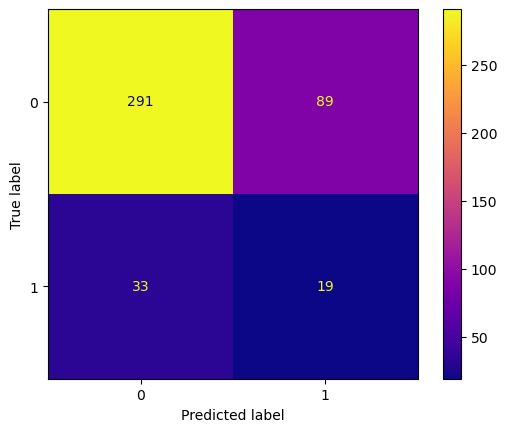

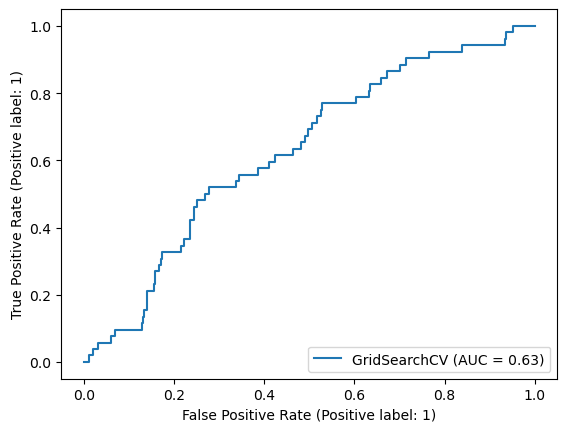

In [46]:
# XGBoost Model
pipe_xgbc = pipe_maker(XGBClassifier)
grid_params_xgbc = [{'clf__booster': ['gbtree', 'gblinear', 'gbdart'],
                  'clf__eta': [.25, .5, .75],
                  'clf__scale_pos_weight': [1000, 10000]}]
gs_xgbc = gridsearch_maker(pipe_xgbc, grid_params_xgbc)
best_acc(gs_xgbc)

XGBClassifier with GridSearchCV hyperparameter optimization underperformed the RandomForestClassifier with 75% accuracy, 26% f1-score, and 65% ROC AUC. Let us see how an ensemble model combining the prior 3 models will perform.

### Model 4: Combined Ensemble Model (LogisticRegression, RandomForestClassifier, XGBClassifier)

Train:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3414
           1       1.00      1.00      1.00      3414

    accuracy                           1.00      6828
   macro avg       1.00      1.00      1.00      6828
weighted avg       1.00      1.00      1.00      6828

Test:               precision    recall  f1-score   support

           0       0.90      0.81      0.85       380
           1       0.21      0.37      0.26        52

    accuracy                           0.75       432
   macro avg       0.55      0.59      0.56       432
weighted avg       0.82      0.75      0.78       432



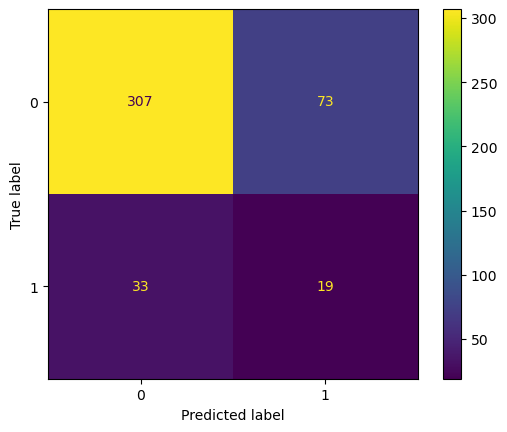

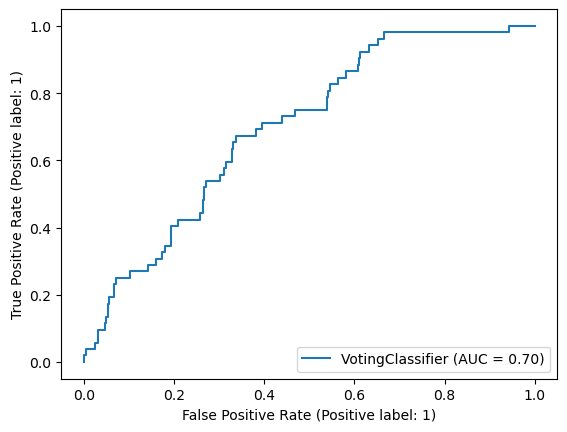

In [47]:
# Combined hypertuned prior models for ultimate ensemble
clf1 = LogisticRegression(max_iter=100, C = 1, class_weight= {0:1,1:1.75}, penalty='l1', solver='saga')
clf2 = RandomForestClassifier(class_weight= {0: 1, 1: 5}, criterion='entropy', max_depth=50)
clf3 = XGBClassifier(booster='gbtree', eta=0.25, scale_pos_weight = 1000, max_depth=15)

w_avg = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('xgb', clf3)],
     voting='soft')
w_avg.fit(X_train_scaled, y_train) 
y_hat_train = w_avg.predict(X_train_scaled)
y_hat_test = w_avg.predict(X_test_scaled)
print(f'Train: {classification_report(y_train, y_hat_train)}')
print(f'Test: {classification_report(y_test, y_hat_test)}')

# Plot confusion matrix and ROC AUC
ConfusionMatrixDisplay.from_estimator(w_avg, X_test_scaled, y_test)
RocCurveDisplay.from_estimator(w_avg, X_test_scaled, y_test);

VotingClassifier consisting of LogisticRegression, RandomForestClassifier, and XGBClassifier performed similarly with 75% accuracy, 27% f1-score, and 70% ROC AUC but was severly overfit. Let us compare the models below.

### Comparing Models

In [48]:
# Model comparison
LogReg = ['Logistic Regression', 0.47, 0.29, 0.7]
RanFor = ['Random Forest', 0.85, 0.24, 0.69]
XGBoost = ['XGBoost', 0.75, 0.26, 0.65]
Combined = ['Combined Models', 0.75, 0.27, 0.7]
all_models = pd.DataFrame(list([LogReg,RanFor,XGBoost,Combined]), 
                          columns=['Model', 'Accuracy', 'f1_score', 'ROC_AUC']).sort_values(['Accuracy'], ascending=False)
all_models

,Model,Accuracy,f1_score,ROC_AUC
1,Random Forest,0.85,0.24,0.69
2,XGBoost,0.75,0.26,0.65
3,Combined Models,0.75,0.27,0.70
0,Logistic Regression,0.47,0.29,0.70


Here we see that RandomForestClassifier had the best model performance in terms of our primary metric. Let us contruct and pickle a RandomForestClassifier model Pipeline and save our utilized features to file.

In [49]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X[vif_features].columns.to_list())
model = clf2.fit(X_train_scaled, y_train)

In [50]:
# Save RandomForest model to disk
pickle.dump(model, open('Model.sav', 'wb'))
pickle.dump(vif_features, open('Features.sav', 'wb'))

## Results

RandomForestClassifier achieved had the greatest accuracy at 85% while tying for the highest ROC AUC at 69%. This means that our model was accurate in predicting season ending injury among NBA players.

The 3 most impactful risk factors for season-ending injury were as follows:

1. Players were 1.38 times more likely to sustain a season-ending injury for every cumulative minute played per season.
2. Players were 1.34 times more likely to sustain a season-ending injury for every 3-pointer they attempted per game.
3. Players were 1.32 times more likely to sustain a season-ending injury for every player foul they committed.

## Conclusions

Players who accumulated heavy minutes throughout the season (cumulative minutes played per season), attempted many 3-pointers (3-pointers attempted per game), and were involved in more physical play (personal fouls per game) were at higher risk of season-ending injury and require strategies to mitigate risks while minimizing impact on play.

## Recommendations

Based on the analysis it is recommended that players and teams implement 3 targeted approaches to reduce risk:

1. Players averging >21 minutes of play per game should consider approved periodic rest strategies throughout the season.
2. Players attempting >2 3-pointers per game should be counseled on safe landing strategies when shooting 3-point shots.
3. Players averging >2 personal fouls per game should be counseled on foul avoidance strategies focused on their specific predominant foul type (blocking foul, offensive foul, etc).

## Future Considerations

The next steps to improve upon this analysis would be to perform a matched cohort risk analysis, matching injured players with non-injured players of similar demographics to stratify risk. Next, segmenting the analysis by injury (ACL, Achilles tendon, etc.) would allow for more focused risk reduction recommendations. Last, extrapolating the findings and recommendations to the weekend warrior would widen the utility of this work and likely reduce risk of injury among this highly passionate cohort.